# EV Enerji Tüketimi ve Menzil Tahmini — XGBoost Çalışması

Bu notebokta **aynı rota üzerinde yapılan çoklu deneylerden** elde edilen verilerle,
- anlık **SoC değişim hızını (pp/s)** modelleyip,
- buradan **enerji tüketimini** ve
- **kalan menzili** tahmin ediyoruz.

## 1) Kurulum & Ortak Ayarlar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb


In [2]:
DATA_PATH = "ev_dataset_multi_target.csv"
SEED      = 42
USE_GPU   = True

In [3]:
df = pd.read_csv(DATA_PATH)
df_range = pd.read_csv(DATA_PATH)
df.shape

(14657, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14657 entries, 0 to 14656
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CELL_V_AVG              14657 non-null  float64
 1   Torque_Measured         14657 non-null  float64
 2   MotorTemperature        14657 non-null  float64
 3   DC_Link_Voltage         14657 non-null  float64
 4   DC_Link_Current         14657 non-null  float64
 5   Experiment_ID           14657 non-null  object 
 6   Average_Velocity        14657 non-null  int64  
 7   Load                    14657 non-null  object 
 8   Direction               14657 non-null  object 
 9   Season                  14657 non-null  object 
 10  slope                   14657 non-null  float64
 11  speed_ms                14657 non-null  float64
 12  acc_ms2                 14657 non-null  float64
 13  power_W                 14657 non-null  float64
 14  cell_voltage_diff       14657 non-null

In [5]:
all_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}

## 2) Metrikler

Regresyon değerlendirmeleri için **MAE**, **RMSE** ve **R²** kullanılmıştır:
- **MAE**: Ortalama mutlak hata; birimin aynısıdır (pp/s).
- **RMSE**: Hataları kareleyip ortalamasının karekökü; büyük hatalara daha duyarlıdır.
- **R²**: Açıklanan varyans oranı (0–1 arası; 1 en iyi).


In [6]:
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

def print_metrics(tag, y_true, y_pred):
    mae, rmse, r2 = metrics(y_true, y_pred)
    print(f"{tag:<6} | MAE: {mae:.8f}  RMSE: {rmse:.8f}  R2: {r2:.5f}")


In [7]:
df.drop(columns=["Experiment_ID","SoC"],  errors="ignore").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14657 entries, 0 to 14656
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CELL_V_AVG              14657 non-null  float64
 1   Torque_Measured         14657 non-null  float64
 2   MotorTemperature        14657 non-null  float64
 3   DC_Link_Voltage         14657 non-null  float64
 4   DC_Link_Current         14657 non-null  float64
 5   Average_Velocity        14657 non-null  int64  
 6   Load                    14657 non-null  object 
 7   Direction               14657 non-null  object 
 8   Season                  14657 non-null  object 
 9   slope                   14657 non-null  float64
 10  speed_ms                14657 non-null  float64
 11  acc_ms2                 14657 non-null  float64
 12  power_W                 14657 non-null  float64
 13  cell_voltage_diff       14657 non-null  float64
 14  soc_net_per_s           14657 non-null

## 3) XGBoost Eğitim Yardımcısı

Bu bölümde tek bir fonksiyon ile:
1. Hedef sütunu (`target`) seçilir,
2. Özellikler (`X`) hazırlanır (kategorikler `category` tipine çevrilir),
3.  train/valid/test ayrımı yapılır ,
4. Model eğitilir ve değerlendirme metrikleri döndürülür.

In [8]:
def run_xgb_for_target(df, target, params, seed=42):

    y = df[target]
    X = df.drop(columns=all_targets,  errors="ignore")

    # Kategorik: object -> category (DMatrix + enable_categorical için)
    for c in X.columns:
        if X[c].dtype == "object":
            X[c] = X[c].astype("category")

    # Train/Val/Test split
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.176, random_state=seed, shuffle=True) # ≈ 70/15/15


    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval   = xgb.DMatrix(X_val,   label=y_val, enable_categorical=True)
    dtest  = xgb.DMatrix(X_test,  label=y_test, enable_categorical=True)

    evals = [(dtrain, "train"), (dval, "eval")]
    model_xgb = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=evals,
        num_boost_round=10000,
        early_stopping_rounds=400,
        verbose_eval=False
        )

    # Tahmin ve metrikler
    y_tr_pred = model_xgb.predict(dtrain, iteration_range=(0, model_xgb.best_iteration + 1))
    y_val_pred = model_xgb.predict(dval, iteration_range=(0, model_xgb.best_iteration + 1))
    y_test_pred = model_xgb.predict(dtest, iteration_range=(0, model_xgb.best_iteration + 1))

    return model_xgb, (y_train, y_tr_pred), (y_val, y_val_pred), (y_test, y_test_pred)


In [9]:
# XGBoost Parametreleri
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.0,
    "device": "cuda" if USE_GPU else "cpu",
    "tree_method": "hist"
}
params


{'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'learning_rate': 0.05,
 'max_depth': 8,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'lambda': 1.0,
 'alpha': 0.0,
 'device': 'cuda',
 'tree_method': 'hist'}

### Target: soc_net_per_s

In [10]:
model_xgb, tr, va, te = run_xgb_for_target(df, "soc_net_per_s", params, seed=SEED)
print_metrics("Train", tr[0], tr[1])
print_metrics("Valid", va[0], va[1])
print_metrics("Test ", te[0], te[1])


Train  | MAE: 0.00222181  RMSE: 0.00000957  R2: 0.77124
Valid  | MAE: 0.00294604  RMSE: 0.00001640  R2: 0.59784
Test   | MAE: 0.00302795  RMSE: 0.00001750  R2: 0.60146


### Target: soc_net_per_s_smooth5

In [11]:
model_xgb_best, tr, va, te = run_xgb_for_target(df, "soc_net_per_s_smooth5", params, seed=SEED)
print_metrics("Train", tr[0], tr[1])
print_metrics("Valid", va[0], va[1])
print_metrics("Test ", te[0], te[1])


Train  | MAE: 0.00052125  RMSE: 0.00000047  R2: 0.97946
Valid  | MAE: 0.00108245  RMSE: 0.00000238  R2: 0.89228
Test   | MAE: 0.00110620  RMSE: 0.00000237  R2: 0.89082


### Target: soc_net_per_s_smooth10


In [12]:
model_xgb, tr, va, te = run_xgb_for_target(df, "soc_net_per_s_smooth10", params, seed=SEED)
print_metrics("Train", tr[0], tr[1])
print_metrics("Valid", va[0], va[1])
print_metrics("Test ", te[0], te[1])


Train  | MAE: 0.00040220  RMSE: 0.00000027  R2: 0.98399
Valid  | MAE: 0.00097321  RMSE: 0.00000213  R2: 0.87352
Test   | MAE: 0.00096506  RMSE: 0.00000214  R2: 0.86790


### Target: soc_net_per_s_30s

In [13]:
model_xgb, tr, va, te = run_xgb_for_target(df, "soc_net_per_s_30s", params, seed=SEED)
print_metrics("Train", tr[0], tr[1])
print_metrics("Valid", va[0], va[1])
print_metrics("Test ", te[0], te[1])


Train  | MAE: 0.00032927  RMSE: 0.00000019  R2: 0.98330
Valid  | MAE: 0.00070150  RMSE: 0.00000101  R2: 0.90630
Test   | MAE: 0.00071419  RMSE: 0.00000107  R2: 0.90289


### Target: soc_net_per_s_60s

In [14]:
model_xgb, tr, va, te = run_xgb_for_target(df, "soc_net_per_s_60s", params, seed=SEED)
print_metrics("Train", tr[0], tr[1])
print_metrics("Valid", va[0], va[1])
print_metrics("Test ", te[0], te[1])


Train  | MAE: 0.00030219  RMSE: 0.00000016  R2: 0.98235
Valid  | MAE: 0.00057771  RMSE: 0.00000072  R2: 0.91890
Test   | MAE: 0.00057103  RMSE: 0.00000070  R2: 0.92291


## Optuna ile Hiperparametre Arama

Optuna ile **Bayesçi arama (TPE)** kullanarak en iyi hiperparametreleri bulunmaktadır.
- Örnek aralıklar: `max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`, `eta`.
- Amaç fonksiyonu: doğrulama **RMSE**’sini en aza indirmek.
- Sonuçlar: `study.best_params` ve (varsa) `best_iteration`.

In [15]:
!pip -q install optuna
import optuna
from optuna.samplers import TPESampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.4 MB/s eta 0:00:00


In [16]:
y = df["soc_net_per_s_smooth5"]
X = df.drop(columns=all_targets,  errors="ignore")

# Kategorik: object -> category (DMatrix + enable_categorical için)
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = X[c].astype("category")

# Train/Val/Test split
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.176, random_state=SEED, shuffle=True) # ≈ 70/15/15

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval   = xgb.DMatrix(X_val,   label=y_val, enable_categorical=True)
dtest  = xgb.DMatrix(X_test,  label=y_test, enable_categorical=True)

In [17]:
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'seed': SEED,
        'tree_method': 'hist',
        'device': 'cuda' if USE_GPU else 'cpu'
    }

    evals = [(dtrain, 'train'), (dval, 'eval')]

    model = xgb.train(params=param,
                      dtrain=dtrain,
                      evals=evals,
                      num_boost_round=10000,
                      early_stopping_rounds=400,
                      verbose_eval=False)

    y_val_pred = model.predict(dval)

    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    trial.set_user_attr("best_iteration", model.best_iteration)

    return rmse

study = optuna.create_study(direction='minimize') # Minimize RMSE

study.optimize(objective, n_trials=50)

[I 2025-08-23 19:56:23,357] A new study created in memory with name: no-name-9c8f2d97-cca8-409a-bb64-5a30646f7954
[I 2025-08-23 19:56:25,610] Trial 0 finished with value: 0.0019453909662560808 and parameters: {'eta': 0.34647690039605783, 'max_depth': 4, 'subsample': 0.858791009761926, 'colsample_bytree': 0.5245683391380652, 'lambda': 0.002639989654504386, 'alpha': 0.536117779083003, 'min_child_weight': 0.02468227953985677}. Best is trial 0 with value: 0.0019453909662560808.
[I 2025-08-23 19:56:26,686] Trial 1 finished with value: 0.0016700929085200363 and parameters: {'eta': 0.43292018083403844, 'max_depth': 7, 'subsample': 0.8118970619581658, 'colsample_bytree': 0.8195087530178427, 'lambda': 0.07190436307412677, 'alpha': 0.003362408270184467, 'min_child_weight': 0.011292136374340117}. Best is trial 1 with value: 0.0016700929085200363.
[I 2025-08-23 19:56:28,176] Trial 2 finished with value: 0.0016026181445178839 and parameters: {'eta': 0.38578047563960916, 'max_depth': 5, 'subsample':

In [18]:
print("Best parameters:", study.best_params)

Best parameters: {'eta': 0.020180532297018775, 'max_depth': 4, 'subsample': 0.7095111904055255, 'colsample_bytree': 0.579002085135503, 'lambda': 0.21321353422294423, 'alpha': 0.01601409878185536, 'min_child_weight': 0.05779867774588815}


In [19]:
best_params = study.best_params.copy()
best_iter   = study.best_trial.user_attrs.get("best_iteration", None)

final_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda" if USE_GPU else "cpu",
    **best_params,
}

num_round = int(best_iter) + 1  # best iterasyona kadar

evals = [(dtrain, "train"), (dval, "eval")]
model_xgb = xgb.train(
    params=final_params,
    dtrain=dtrain,
    evals=evals,
    num_boost_round=num_round,
    verbose_eval=False
    )

# Tahmin ve metrikler
y_tr_pred = model_xgb.predict(dtrain, iteration_range=(0, num_round))
y_val_pred = model_xgb.predict(dval,   iteration_range=(0, num_round))
y_test_pred = model_xgb.predict(dtest, iteration_range=(0, num_round))

print_metrics("Train", tr[0], tr[1])
print_metrics("Valid", va[0], va[1])
print_metrics("Test ", te[0], te[1])

Train  | MAE: 0.00030219  RMSE: 0.00000016  R2: 0.98235
Valid  | MAE: 0.00057771  RMSE: 0.00000072  R2: 0.91890
Test   | MAE: 0.00057103  RMSE: 0.00000070  R2: 0.92291


## 5) Gruplandırma (Experiment_ID) ile Eğitim

Bu kısımda **deney bazlı** (aynı rota–farklı koşullar) ayrımı korumak için **grouped split** uygulanır.
- **Hedef:** `soc_net_per_s_smooth5` (örnek)
- **Grup Değişkeni:** `Experiment_ID`
- **Neden gerekli?** Deney içi ardışık gözlemler korelasyonlu olduğundan sızıntı olmaması için
aynı `Experiment_ID`’nin train/valid/test’e **aynı anda girmesi engellenir**.

> **Beklenen etki:** Rastgele ayrımdan daha **gerçekçi fakat genelde daha düşük** skorlar.
Bu düşüş, gerçek dünyadaki genelleme hatasına daha yakın olduğumuzun bir işaretidir.

**Not:** Bu bölümde `df_range`, menzil analizi için gereken ek sütunları (ör. hız eşikleri, tüketim, vb.) içerir.

In [20]:
def run_xgb_for_target(df, target, params, seed=42):

    y = df_range[target]
    X = df_range.drop(columns=all_targets,  errors="ignore")

    # Kategorik: object -> category (DMatrix + enable_categorical için)
    for c in X.columns:
        if X[c].dtype == "object":
            X[c] = X[c].astype("category")


    grp = df_range["Experiment_ID"].astype(str).values

    # --- Group-aware split: 70 / 15 / 15
    gss1 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)
    trval_idx, te_idx = next(gss1.split(X, y, groups=grp))

    X_trval, y_trval = X.iloc[trval_idx], y.iloc[trval_idx]
    X_test,  y_test  = X.iloc[te_idx],    y.iloc[te_idx]
    grp_trval = grp[trval_idx]

    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.176, random_state=seed)  # ~ toplamda 15%
    tr_idx, va_idx = next(gss2.split(X_trval, y_trval, groups=grp_trval))

    X_train, y_train = X_trval.iloc[tr_idx], y_trval.iloc[tr_idx]
    X_val,   y_val   = X_trval.iloc[va_idx], y_trval.iloc[va_idx]

    # güvenlik kontrolleri: gruplar bölünmüş mü?
    assert set(grp_trval[tr_idx]).isdisjoint(set(grp_trval[va_idx]))
    assert set(pd.unique(grp_trval)).isdisjoint(set(pd.unique(grp[te_idx])))

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval   = xgb.DMatrix(X_val,   label=y_val, enable_categorical=True)
    dtest  = xgb.DMatrix(X_test,  label=y_test, enable_categorical=True)

    evals = [(dtrain, "train"), (dval, "eval")]
    model_xgb = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=evals,
        num_boost_round=10000,
        early_stopping_rounds=400,
        verbose_eval=False
        )

    # Tahmin ve metrikler
    y_tr_pred = model_xgb.predict(dtrain, iteration_range=(0, model_xgb.best_iteration + 1))
    y_val_pred = model_xgb.predict(dval, iteration_range=(0, model_xgb.best_iteration + 1))
    y_test_pred = model_xgb.predict(dtest, iteration_range=(0, model_xgb.best_iteration + 1))

    return model_xgb, (y_train, y_tr_pred), (y_val, y_val_pred), (y_test, y_test_pred)


In [21]:
model_xgb, tr, va, te = run_xgb_for_target(df, "soc_net_per_s_smooth5", params, seed=SEED)
print_metrics("Train", tr[0], tr[1])
print_metrics("Valid", va[0], va[1])
print_metrics("Test ", te[0], te[1])


Train  | MAE: 0.00067619  RMSE: 0.00000081  R2: 0.96185
Valid  | MAE: 0.00192438  RMSE: 0.00000616  R2: 0.75425
Test   | MAE: 0.00187284  RMSE: 0.00000590  R2: 0.76775


## 6) Menzil Tahmini

In [22]:
# MODEL TAHMİNİ (Feature mismatch fix): df["y_pred_soc_rate_pps"]

PRED_COL    = "y_pred_soc_rate_pps"
usable_kwh_est = 62.7   # kWh (kalan menzil hücrelerinde kullanılıyor)

# 1) Modele kayıtlı özellik adlarını al
feat_list = getattr(model_xgb_best, "feature_names", None)

X_pred = df.copy()

# Eğitimde olmayan hedef/sentetik kolonları at (uymasın diye)
drop_candidates = [
    "soc_net_per_s_smooth5","soc_net_per_s_30s","soc_net_per_s_60s","soc_rate_pps",
    "target","y","y_true","y_pred","y_pred_soc_rate_pps"  # olası isimler
]
X_pred = X_pred.drop(columns=[c for c in drop_candidates if c in X_pred.columns], errors="ignore")


X_pred = X_pred[feat_list]

# Kategorik tipleri düzelt (XGB DMatrix categorical desteği için)
for c in X_pred.columns:
    if X_pred[c].dtype == "object":
        X_pred[c] = X_pred[c].astype("category")

# 3) DMatrix ve tahmin
dmat = xgb.DMatrix(X_pred, enable_categorical=True)
y_pred = model_xgb_best.predict(dmat)


df[PRED_COL] = y_pred.astype(float)
print(f"[OK] {PRED_COL} eklendi. örnek:", df[PRED_COL].head(3).round(6).tolist())


[OK] y_pred_soc_rate_pps eklendi. örnek: [0.002266, 0.002449, 0.002709]


In [23]:
# DENEY BAZLI KALAN MENZIL (MODEL KULLANARAK)

rows = []
for exp_id, g in df.groupby("Experiment_ID"):

    # MODEL tabanlı toplam enerji (kWh)
    pred_energy_kwh_per_s = usable_kwh_est * (g["y_pred_soc_rate_pps"] / 100.0)
    energy_kwh = float((pred_energy_kwh_per_s * 1.0).sum())  # dt=1s

    # Deney toplam mesafe (km)
    dist_km = 2.0

    if energy_kwh <= 0 or dist_km <= 0:
        continue

    # MODEL ortalama tüketim (kWh/km)
    avg_cons = energy_kwh / dist_km

    # Deney sonundaki SoC ve kalan enerji
    soc_end = float(g["SoC"].iloc[-1])
    remaining_kwh = usable_kwh_est * soc_end / 100.0

    # Kalan menzil (km)
    remaining_range_km = remaining_kwh / avg_cons

    rows.append({
        "Experiment_ID": exp_id,
        "model_avg_cons_kWh_per_km": avg_cons,
        "SoC_end_%": soc_end,
        "remaining_kWh": remaining_kwh,
        "Remaining_Range_km_MODEL": remaining_range_km,
        "model_energy_used_kWh": energy_kwh
    })

exp_remaining_df = pd.DataFrame(rows).sort_values("Remaining_Range_km_MODEL", ascending=False)
display(exp_remaining_df.head(20))


,Experiment_ID,model_avg_cons_kWh_per_km,SoC_end_%,remaining_kWh,Remaining_Range_km_MODEL,model_energy_used_kWh
6,Experiment_15,0.003297,56.62,35.50074,10767.681902,0.006594
2,Experiment_11,0.259789,65.59,41.12493,158.301200,0.519578
3,Experiment_12,0.271579,64.71,40.57317,149.397549,0.543157
33,Experiment_8,0.294355,68.12,42.71124,145.101330,0.588709
34,Experiment_9,0.293445,67.16,42.10932,143.499858,0.586890
12,Experiment_20,0.330526,70.82,44.40414,134.343987,0.661051
13,Experiment_21,0.333459,69.08,43.31316,129.890667,0.666917
1,Experiment_10,0.298824,51.96,32.57892,109.023919,0.597647
32,Experiment_7,0.332996,47.98,30.08346,90.341806,0.665992
14,Experiment_22,0.396049,52.95,33.19965,83.827101,0.792098


In [26]:
# GERÇEK vs MODEL KARŞILAŞTIRMA

rows = []
for exp_id, g in df.groupby("Experiment_ID"):

    # --- Gerçek (SoC düşüşünden) ---
    soc_start = float(g["SoC"].iloc[0])
    soc_end   = float(g["SoC"].iloc[-1])
    soc_drop  = soc_start - soc_end
    dist_true = 2.0

    true_energy = usable_kwh_est * (soc_drop / 100.0)
    true_avg_cons = true_energy / dist_true
    true_remaining = (usable_kwh_est * soc_end / 100.0) / true_avg_cons

    # --- Model (tahmin edilen SoC hızından) ---
    pred_energy = float((usable_kwh_est * (g["y_pred_soc_rate_pps"] / 100.0) * 1.0).sum())
    dist_pred = dist_true  # odometer kullanıldığı için mesafe aynı
    if pred_energy <= 0:
        continue

    pred_avg_cons = pred_energy / dist_pred
    pred_remaining = (usable_kwh_est * soc_end / 100.0) / pred_avg_cons

    rows.append({
        "Experiment_ID": exp_id,
        "true_avg_cons_kWh_per_km": true_avg_cons,
        "pred_avg_cons_kWh_per_km": pred_avg_cons,
        "true_remaining_range_km": true_remaining,
        "pred_remaining_range_km": pred_remaining,
        "delta_range_km": pred_remaining - true_remaining,
        "perc_error_%": 100.0 * (pred_remaining - true_remaining) / true_remaining
    })

compare_df = pd.DataFrame(rows).sort_values("Experiment_ID")
display(compare_df.head(20))


,Experiment_ID,true_avg_cons_kWh_per_km,pred_avg_cons_kWh_per_km,true_remaining_range_km,pred_remaining_range_km,delta_range_km,perc_error_%
0,Experiment_1,0.485925,0.487493,75.458065,75.215362,-0.242703,-0.321639
1,Experiment_10,0.307230,0.298824,106.040816,109.023919,2.983102,2.813164
2,Experiment_11,0.266475,0.259789,154.329412,158.301200,3.971788,2.573578
3,Experiment_12,0.275880,0.271579,147.068182,149.397549,2.329367,1.583869
4,Experiment_13,0.561165,0.556223,70.949721,71.580049,0.630328,0.888415
5,Experiment_14,0.476520,0.467184,76.657895,78.189786,1.531891,1.998347
6,Experiment_15,0.495330,0.003297,71.670886,10767.681902,10696.011016,14923.787888
7,Experiment_16,0.511005,0.497366,75.447853,77.516783,2.068931,2.742200
8,Experiment_17,0.426360,0.428152,68.117647,67.832543,-0.285104,-0.418546
9,Experiment_18,0.398145,0.403822,70.897638,69.901023,-0.996614,-1.405709


## 7) Model Tahmini ve Karşılaştırma

### 1. Anlık Tahmin
Eğitilen XGBoost modeli, her satır için **SoC düşüş hızını (pp/s)** tahmin etmektedir.  
- Bu değer `y_pred_soc_rate_pps` kolonunda tutulur.  
- Yüksek değerler → daha hızlı enerji kaybı → daha yüksek tüketim anlamına gelir.

### 2. Deney Bazlı Model Çıktıları
Her bir **Experiment_ID** için modelden türetilen özet bilgiler:  
- **model_avg_cons_kWh_per_km** → Modelin hesapladığı ortalama enerji tüketimi (kWh/km)  
- **SoC_end_%** → Deney sonunda bataryada kalan SoC (%)  
- **remaining_kWh** → Kalan kullanılabilir enerji (kWh)  
- **Remaining_Range_km_MODEL** → Tahmini kalan menzil (km)  
- **model_distance_km** → Deney boyunca kat edilen mesafe (km)  
- **model_energy_used_kWh** → Tahmini kullanılan enerji (kWh)

Bu tablo, her deney sonunda aracın kalan menzilinin **model üzerinden tahmin edilmesini** sağlar.

### 3. Gerçek vs Model Karşılaştırması
Aynı deneyler için ayrıca **gerçek veriler** ile karşılaştırma yapılmıştır:  
- **true_avg_cons_kWh_per_km** → Gerçek SoC düşüşünden hesaplanan ortalama tüketim  
- **pred_avg_cons_kWh_per_km** → Model tahmini tüketim  
- **true_remaining_range_km** → Gerçek kalan menzil  
- **pred_remaining_range_km** → Model tahmini kalan menzil  
- **delta_range_km** → Model ile gerçek arasındaki fark (km)  
- **perc_error_%** → Modelin menzili ne kadar fazla/eksik tahmin ettiği (%)

Bu bölüm, modelin **doğruluğunu ölçmek** için kullanılır.



In [29]:
# 15 numaralı deneyi çıkar
compare_df = compare_df[compare_df["Experiment_ID"] != "Experiment_15"]
exp_remaining_df = exp_remaining_df[exp_remaining_df["Experiment_ID"] != "Experiment_15"]

# 1) Ortalama tüketim (kWh/km): Gerçek vs Model (line chart)
def plot_avg_consumption(compare_df: pd.DataFrame, savepath: str | None = None):
    cdf = compare_df.copy().sort_values("Experiment_ID")
    x = cdf["Experiment_ID"]
    y_true = cdf["true_avg_cons_kWh_per_km"]
    y_pred = cdf["pred_avg_cons_kWh_per_km"]

    plt.figure(figsize=(8,5))
    plt.plot(x, y_true, marker="o", label="Gerçek")
    plt.plot(x, y_pred, marker="s", label="Model")
    plt.title("Ortalama Tüketim (kWh/km) - Gerçek vs Model")
    plt.xlabel("Experiment_ID")
    plt.ylabel("kWh/km")
    plt.legend()
    plt.grid(True)
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


# 2) Kalan menzil (km): Gerçek vs Model (bar chart)
def plot_remaining_range(compare_df: pd.DataFrame, savepath: str | None = None):
    cdf = compare_df.copy().sort_values("Experiment_ID")
    x = np.arange(len(cdf))
    width = 0.4

    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, cdf["true_remaining_range_km"], width=width, label="Gerçek")
    plt.bar(x + width/2, cdf["pred_remaining_range_km"], width=width, label="Model")
    plt.title("Kalan Menzil (km) - Gerçek vs Model")
    plt.xlabel("Experiment_ID")
    plt.ylabel("km")
    plt.xticks(x, cdf["Experiment_ID"].tolist())
    plt.legend()
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


# 3) Menzil hatası (%): Model - Gerçek (bar chart)
def plot_range_error_percent(compare_df: pd.DataFrame, savepath: str | None = None):
    cdf = compare_df.copy().sort_values("Experiment_ID")
    if "perc_error_%" not in cdf.columns:
        # güvenli hesap: (model - gerçek)/gerçek * 100
        cdf["perc_error_%"] = 100.0 * (
            (cdf["pred_remaining_range_km"] - cdf["true_remaining_range_km"])
            / cdf["true_remaining_range_km"].replace(0, np.nan)
        )

    plt.figure(figsize=(8,5))
    plt.bar(cdf["Experiment_ID"], cdf["perc_error_%"])
    plt.title("Menzil Hatası (%) - Model vs Gerçek")
    plt.xlabel("Experiment_ID")
    plt.ylabel("% Hata")
    plt.axhline(0, linestyle="--")
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


# 4) Deney bazlı: Model tüketimi ve tahmini kalan menzil (dual chart)
def plot_exp_summary(exp_remaining_df: pd.DataFrame, top_k: int = 15, savepath: str | None = None):
    edf = exp_remaining_df.copy().sort_values("Experiment_ID").head(top_k)

    # a) model tüketim (kWh/km)
    plt.figure(figsize=(8,5))
    plt.bar(edf["Experiment_ID"], edf["model_avg_cons_kWh_per_km"])
    plt.title("Model Ortalama Tüketim (kWh/km)")
    plt.xlabel("Experiment_ID")
    plt.ylabel("kWh/km")
    if savepath: plt.savefig(savepath.replace(".png","_cons.png"), bbox_inches="tight", dpi=150)
    plt.show()

    # b) model kalan menzil (km)
    plt.figure(figsize=(8,5))
    plt.bar(edf["Experiment_ID"], edf["Remaining_Range_km_MODEL"])
    plt.title("Model Tahmini Kalan Menzil (km)")
    plt.xlabel("Experiment_ID")
    plt.ylabel("km")
    if savepath: plt.savefig(savepath.replace(".png","_range.png"), bbox_inches="tight", dpi=150)
    plt.show()


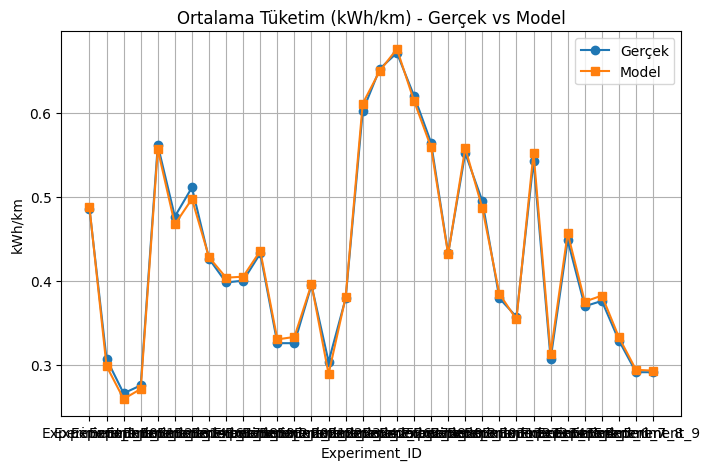

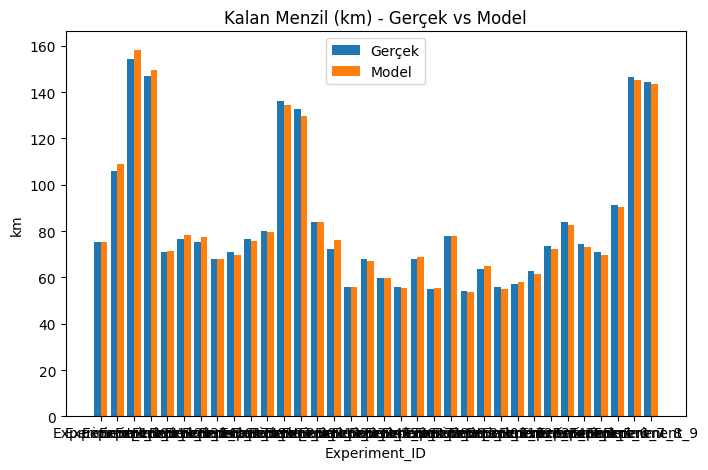

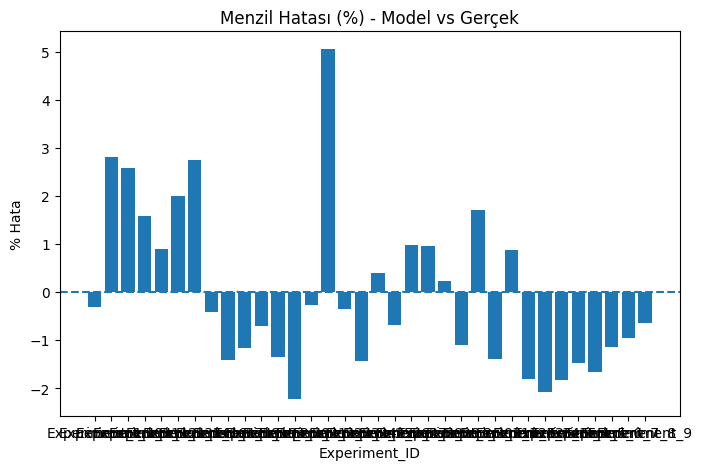

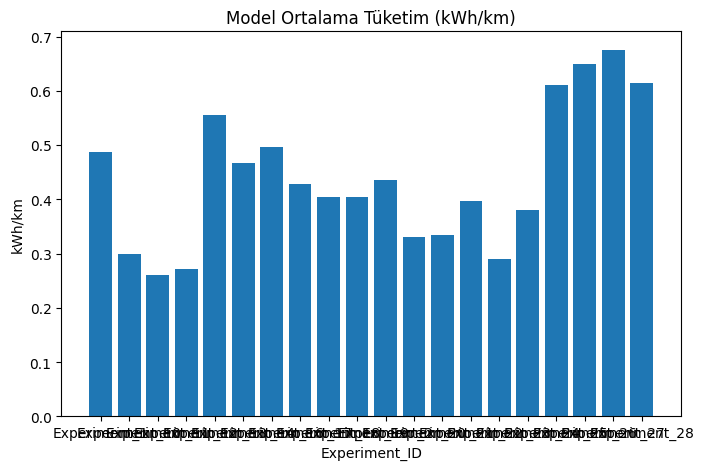

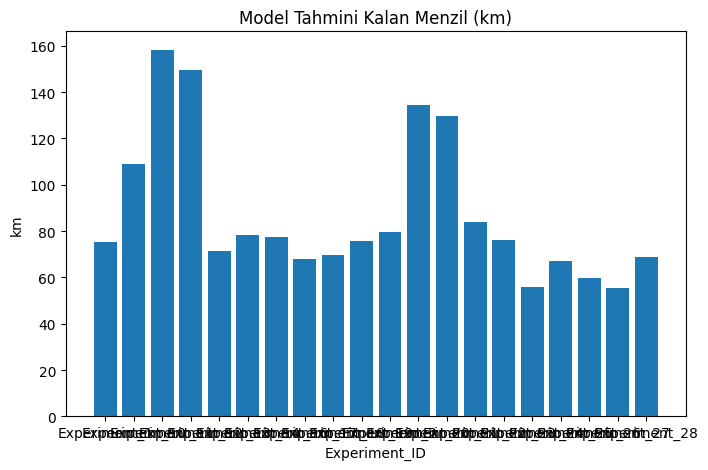

In [31]:
plot_avg_consumption(compare_df)
plot_remaining_range(compare_df)
plot_range_error_percent(compare_df)

plot_exp_summary(exp_remaining_df, top_k=20)


## 8) Faktörlerin Etkisi

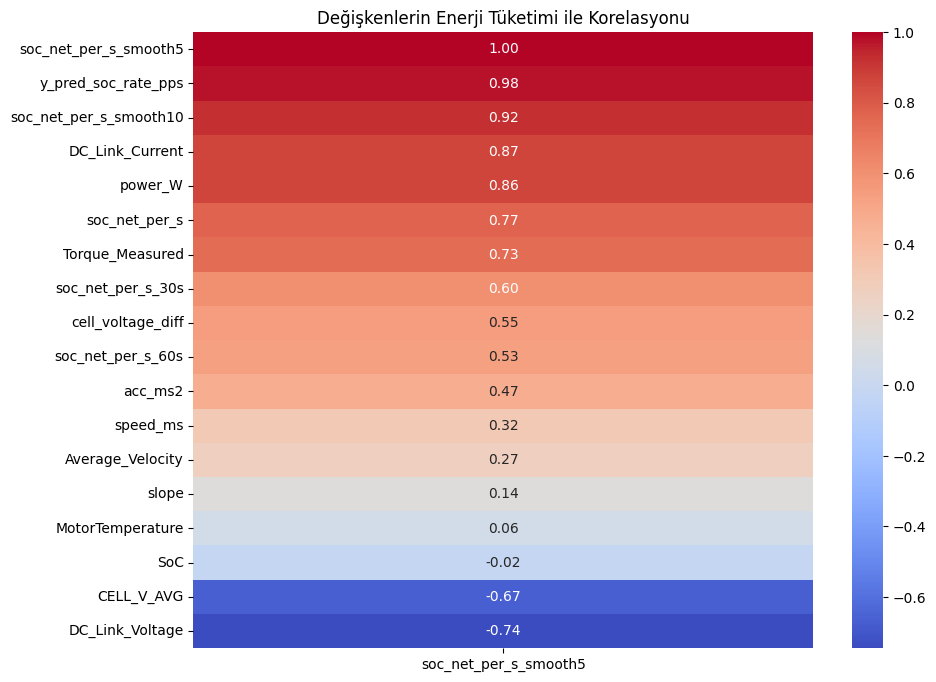

In [32]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr[['soc_net_per_s_smooth5']].sort_values(by='soc_net_per_s_smooth5', ascending=False),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Değişkenlerin Enerji Tüketimi ile Korelasyonu")
plt.show()

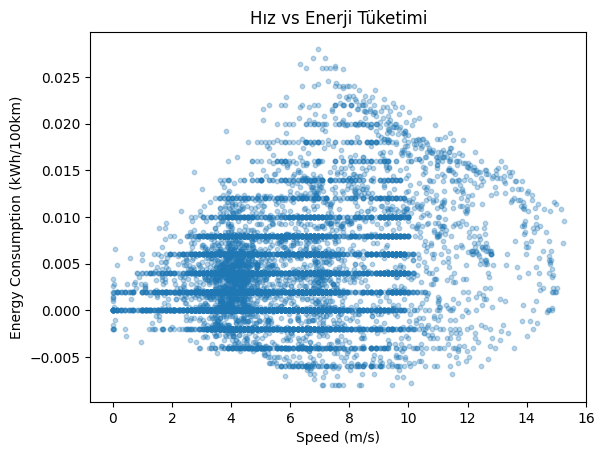

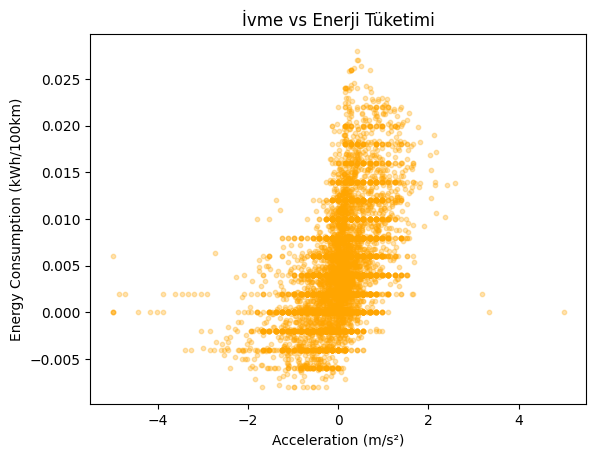

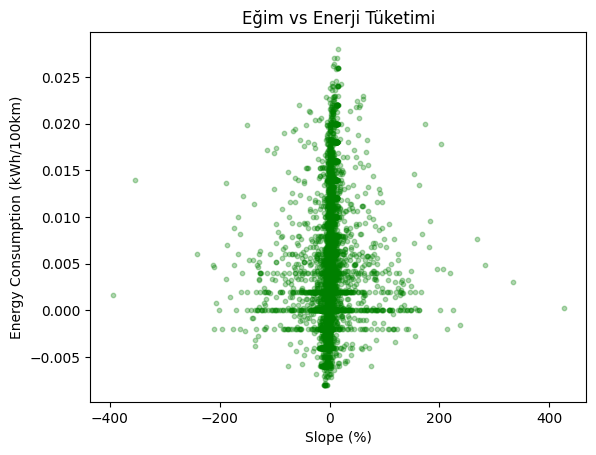

In [33]:
# Hız ve Tüketim
plt.scatter(df["speed_ms"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10)
plt.xlabel("Speed (m/s)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("Hız vs Enerji Tüketimi")
plt.show()

# İvme ve Tüketim
plt.scatter(df["acc_ms2"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="orange")
plt.xlabel("Acceleration (m/s²)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("İvme vs Enerji Tüketimi")
plt.show()

# Eğim ve Tüketim
plt.scatter(df["slope"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="green")
plt.xlabel("Slope (%)")
plt.ylabel("Energy Consumption (kWh/100km)")
plt.title("Eğim vs Enerji Tüketimi")
plt.show()

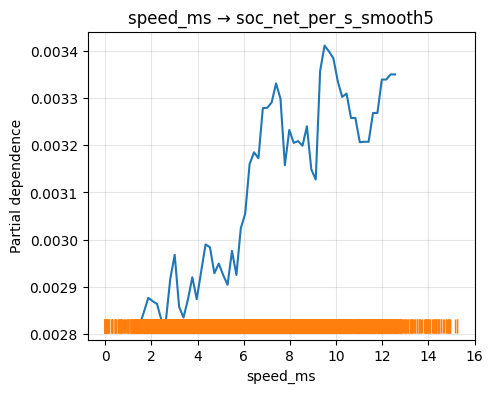

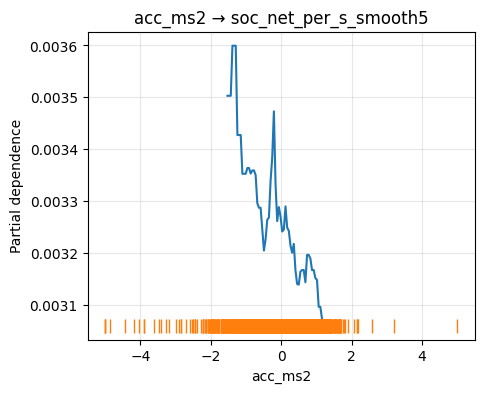

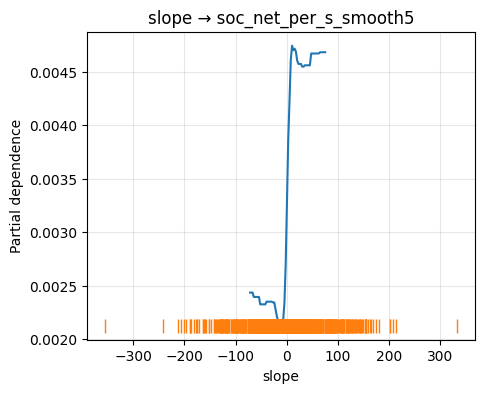

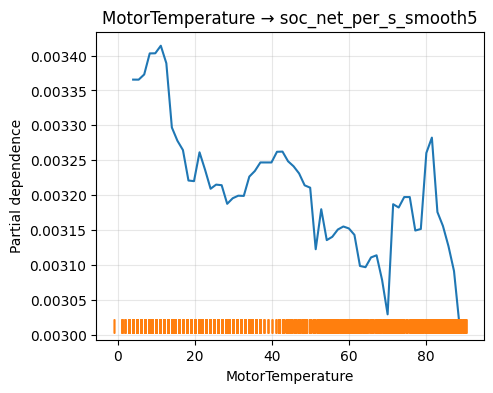

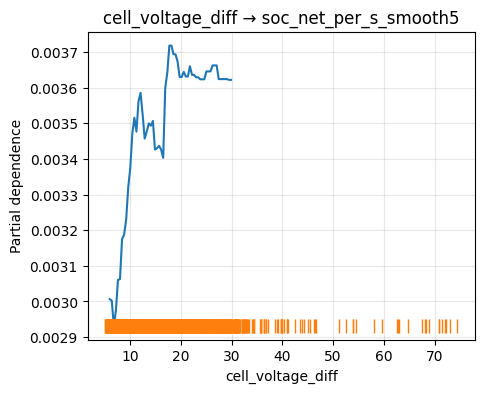

In [39]:
import numpy as np, matplotlib.pyplot as plt, xgboost as xgb

def plot_pdp(booster, X, features, target="soc_net_per_s_smooth5", grid=60):
    for f in features:
        xs = np.linspace(X[f].quantile(.01), X[f].quantile(.99), grid)
        ys = [booster.predict(xgb.DMatrix(X.assign(**{f:v}), enable_categorical=True)).mean() for v in xs]
        plt.figure(figsize=(5,4))
        plt.plot(xs, ys); plt.plot(X[f], [min(ys)]*len(X), '|', ms=10)
        plt.title(f"{f} → {target}"); plt.xlabel(f); plt.ylabel("Partial dependence"); plt.grid(True, alpha=0.3)
        plt.show()

features = [f for f in ["speed_ms","acc_ms2","slope","MotorTemperature","cell_voltage_diff"] if f in X_train.columns]
plot_pdp(model_xgb_best, X_train, features)
